# Machine learning and neural network study on mobile application classification

## Introduction

Smartphone apps play a very important role in our daily lives. They are used every day, for example to communicate, play games, and browse the Internet. App stores provide easy access to more than a million applications. One such store is the Google Play, which supports Android system. On the Google Play store users can choose from more than a 3 million mobile applications for various mobile devices. It is such a simple tool that with a few clicks user can search and buy apps or read its reviews.

Mobile application classification is not easy these days. We have a large number of them, which means we also need a good prepared set of categories to describe them unambiguously. One method that allows rapid classification is machine learning and neural networks, which have gained popularity in recent years. As a part of Sages course, I conducted a classification of mobile apps based on their description in the Google Play store.

## Data acquisition

The data for over 2 million applications were downloaded from [Kaggle](https://www.kaggle.com/datasets/gauthamp10/google-playstore-apps). In order to obtain app descriptions, I have used [Google-Play-Scraper](https://github.com/JoMingyu/google-play-scraper) tool. The project focused only on apps that had a description in English.

To speed up the data acquisition stage, 2312944 applications were divided into 24 parts and sent to WCSS (Wroclaw Center for Networking and Supercomputing). The data preparation stage was as follows:

1. For each chunk, I downloaded the latest description and category status from the Google Play Store (**1-download_data.py**).
2. Then, using spaCy library, the applications were verified for the availability of the English description version (**2-drop_non_english.py**).
3. If English description version was detected, it was followed by the extraction of individual words from the description (**3-split_words.py**). The list of words was saved to the newly created "Words" column. However, several rules for selecting words were applied:
    - rejected the numbers
    - rejected url and email
    - rejected out-of-vocabulary
    - rejected stop words
    - rejected words that were less than 2 letters long
    - performed lemmatization

## Data loading

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# sklearn
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import make_scorer, top_k_accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

# tensorflow and adds-on
import joblib
import lightgbm as lgbm
import tensorflow as tf
import tensorflow_addons as tfa

# text cleaner
from bs4 import BeautifulSoup
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

In [2]:
nlp = spacy.load("en_core_web_lg")

def get_lang_detector(nlp, name):
    return LanguageDetector()

Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [3]:
df_data = pd.read_csv("datasets/Google-Playstore.csv")
df_data.rename(columns={"App Id": "appId"}, inplace=True)

df_desc = pd.DataFrame(data=[])

for i in range(0,24):
    df_part = pd.read_csv(f"datasets/Google-Playstore_descriptions_{i}.csv")
    df_desc = pd.concat((df_desc, df_part))
    del df_part
    
df = df_data.merge(df_desc, how="inner", on="appId")
df.reset_index(inplace=True, drop=True)

del df_data, df_desc

## Exploratory data analysis (EDA)

The expoloraty data analysis was done to better visualize and understand data set before undergoing the model building process.

In [4]:
df.tail(5)

,App Name,appId,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time,genre,Words,description
1230032,Engineers Careers,com.eventapps.eventapps,Business,0.0,0.0,100+,100.0,353,True,0.0,...,"Feb 29, 2020",Everyone,NaN,False,False,False,2021-06-16 12:59:18,Business,welcome engineer career official app engineer ...,Welcome to Engineers Careers official app.\r\n...
1230033,Lero TOEFL Recorder + Timer,com.toefltimer,Education,3.4,17.0,"1,000+",1000.0,1980,True,0.0,...,"Dec 14, 2018",Everyone,https://lerodoe.wordpress.com/app-privacy-poli...,True,False,False,2021-06-16 12:59:18,Education,contain necessary feature practice toefl speak...,It contains all the necessary features for pra...
1230034,ORU Online,com.threedream.oruonline,Education,0.0,0.0,100+,100.0,430,True,0.0,...,"Feb 02, 2018",Everyone,http://www.oru.edu/about-oru/privacy-policy.php,False,False,False,2021-06-16 12:59:19,Education,oru online app opportunity remote student inte...,The ORU online app is an opportunity for the r...
1230035,Data Structure,datastructure.appoworld.datastucture,Education,0.0,0.0,100+,100.0,202,True,0.0,...,"Aug 19, 2018",Everyone,https://appoworld.000webhostapp.com/datastruct...,False,False,False,2021-06-16 12:59:19,Education,contain datum structure handwritten note impor...,"Contain Data Structure Handwritten Notes, Some..."
1230036,Devi Suktam,ishan.devi.suktam,Music & Audio,3.5,8.0,"1,000+",1000.0,2635,True,0.0,...,"May 05, 2021",Everyone,https://docs.google.com/document/d/1x-9reZuLRX...,True,False,False,2021-06-16 12:59:19,Music & Audio,image wallpaper set mantra alarm ringtone engl...,1.Set Images as wallpaper..\r\n\r\n2..Set the ...


After initially limiting the list of apps, we have 1230037 mobile apps that we can analyze and use in classification problem.

There are 27 columns in the data. The columns 1-24 were extracted from previously prepared data set on Kaggle. The columns 25-27, i.e. "genre", "Words", and "description", were obtained from Google Play store by my own.

The categories of each application are stored in the "Category" and "genre" columns. Due to the fact that the app descriptions were downloaded on the basis of the latest data, I will focus only on the "genre" column here.

In [5]:
df["genre"].unique()

array(['Tools', 'Social', 'Libraries & Demo', 'Lifestyle',
       'Personalization', 'Racing', 'Maps & Navigation', 'Food & Drink',
       'Books & Reference', 'Arcade', 'Entertainment', 'Photography',
       'Travel & Local', 'Health & Fitness', 'Education', 'Board',
       'Sports', 'Educational', 'Business', 'Music & Audio',
       'Auto & Vehicles', 'Casual', 'Puzzle', 'Productivity',
       'Art & Design', 'Beauty', 'House & Home', 'Card', 'Finance',
       'Trivia', 'Simulation', 'Adventure', 'Word', 'Events', 'Shopping',
       'Weather', 'Action', 'Medical', 'Music', 'Communication',
       'Role Playing', 'Video Players & Editors', 'Dating', 'Strategy',
       'News & Magazines', 'Casino', 'Comics', 'Parenting'], dtype=object)

Mobile apps in the Google Play store are divided into 48 categories, but some are duplicated and worth combining. The "Music & Audio" category can be combined with the "Music" category. Similarly "Educational" and "Education".

In [6]:
df["genre"] = df["genre"].str.replace("Music & Audio", "Music")
df["genre"] = df["genre"].str.replace("Educational", "Education")

In [7]:
df.columns

Index(['App Name', 'appId', 'Category', 'Rating', 'Rating Count', 'Installs',
       'Minimum Installs', 'Maximum Installs', 'Free', 'Price', 'Currency',
       'Size', 'Minimum Android', 'Developer Id', 'Developer Website',
       'Developer Email', 'Released', 'Last Updated', 'Content Rating',
       'Privacy Policy', 'Ad Supported', 'In App Purchases', 'Editors Choice',
       'Scraped Time', 'genre', 'Words', 'description'],
      dtype='object')

Some of these columns are useless and can be deleted. We can also rename "genre" to "Category".

In [8]:
to_drop = ["App Name", "Category", "Installs", 
           "Minimum Installs", "Price", "Currency", 
           "Size", "Minimum Android", "Developer Id", 
           "Developer Website", "Developer Email", "Released", 
           "Last Updated", "Content Rating", "Privacy Policy", 
           "In App Purchases", "Editors Choice", "Scraped Time"
]

df.drop(to_drop, axis="columns", inplace=True)
df.rename(columns={"genre": "Category"}, inplace=True)

In [9]:
df.isna().sum()

appId                   0
Rating              12256
Rating Count        12256
Maximum Installs        0
Free                    0
Ad Supported            0
Category                0
Words                   0
description             0
dtype: int64

There are missing values in the "Rating" and "Rating Count" columns. In our case, this does not lead to serious problems, because here we are classifying based on the words, so both columns will not be taken into account when learning the machine learning models.

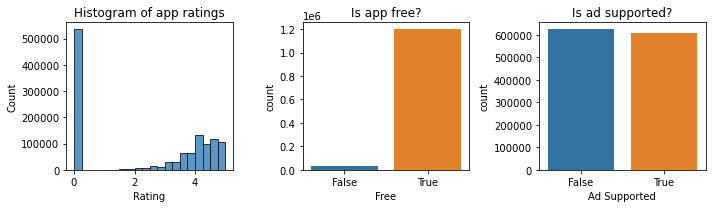

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

data_plot = {
    "Rating": "Histogram of app ratings",
    "Free": "Is app free?",
    "Ad Supported": "Is ad supported?",
}

for i, (key, value) in enumerate(data_plot.items()):
    axs[i].set_title(value)
    
    if key in ["Free", "Ad Supported"]:
        sns.countplot(x=key, data=df, ax=axs[i])
    else:
        sns.histplot(x=key, data=df, ax=axs[i], bins=20)

fig.tight_layout()
fig.show()

As one may see, most apps do not have a rating. In turn, the ratings given are mostly positive. In addition, the largest number of free apps is probably profiting from enabled ads. The result for ad support is interesting, as here we see an equal share of both types of apps, indicating that we are likely to find free apps in the store without ads.

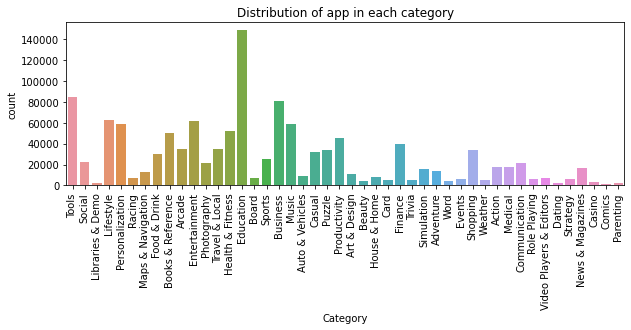

In [11]:
plt.figure(figsize=(10,3))
sns.countplot(x="Category", data=df)
plt.title("Distribution of app in each category")
plt.xticks(rotation="vertical")
plt.show()

The distribution of the number of applications in each category indicates that we will have an imbalanced dataset problem here. The largest number of applications is in the "Education" category, followed by "Tools" and "Business." Due to the plethora of applications, we will use a weighted sample method to train our models.

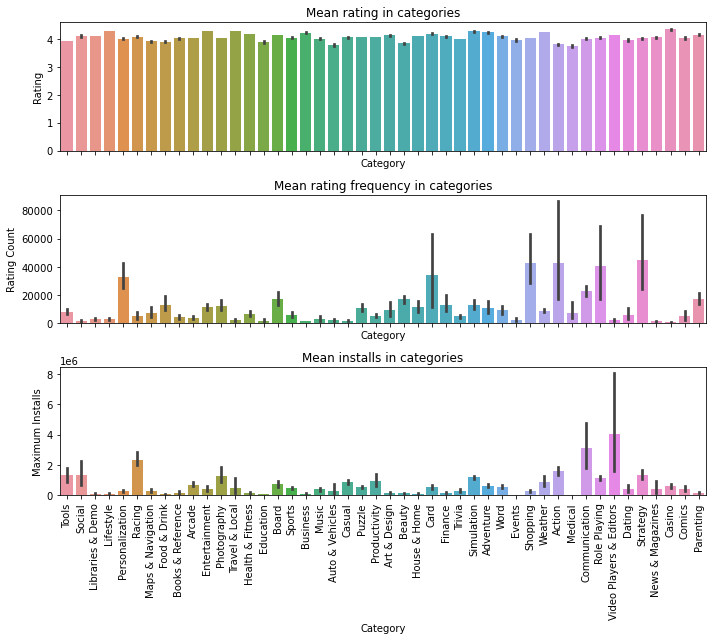

In [12]:
fig, (axs) = plt.subplots(3, 1, sharex=True, figsize=(10, 9))

data_plot = {
    "Rating": "Mean rating in categories",
    "Rating Count": "Mean rating frequency in categories",
    "Maximum Installs": "Mean installs in categories",
}

for i, (key, value) in enumerate(data_plot.items()):
    axs[i].set_title(value)
    sns.barplot(x="Category", y=key, data=df[df[key] > 0], ax=axs[i])
    axs[i].tick_params(axis="x", rotation=90)

fig.tight_layout()
fig.show()

After discarding apps with zero ratings and installations, we can see the distribution of ratings in each category is similar at around 4.0. Personalization, card, shopping, action, communication, role playing, and strategy apps have the most ratings. Interestly, the most installs have video apps.

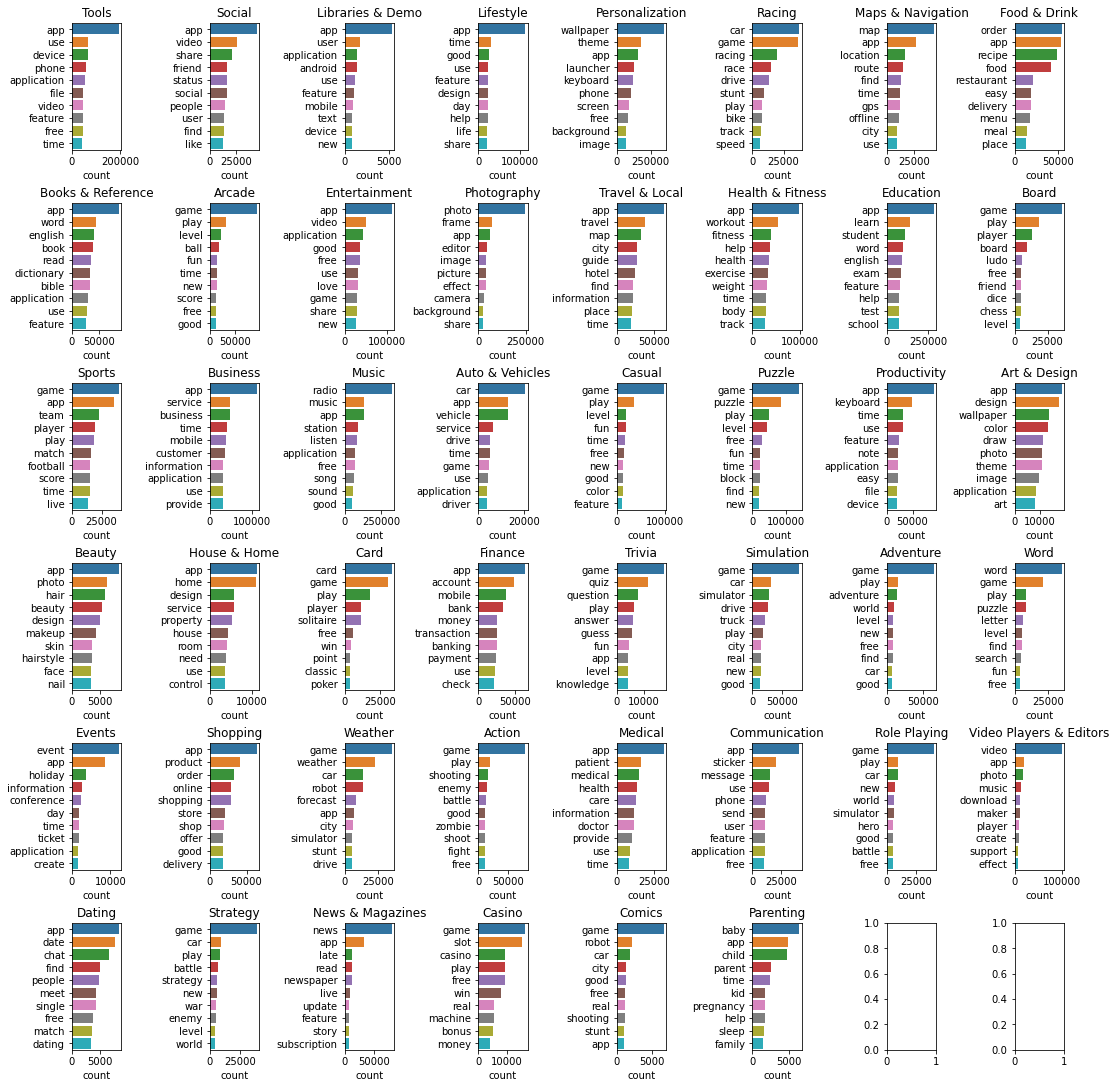

In [13]:
x = 8
y = 6

fig, axs = plt.subplots(y, x, constrained_layout=True, figsize=(15,15))

datay = [i for i in np.arange(0, y) for _ in np.arange(0, x)]
datax = [i for _ in np.arange(0, y) for i in np.arange(0, x)]

for i, category in enumerate(df["Category"].unique()):    
    words = df[df["Category"] == category]["Words"].str.cat(sep=" ")
    words = pd.Series(data=words.split())
    sns.countplot(y=words, ax=axs[datay[i], datax[i]], orient="h",
                  order=words.value_counts().iloc[0:10].index)
    axs[datay[i], datax[i]].set_title(category)

plt.show()

Analyzing the words in each category will allow us to determine whether it is possible to classify the application based on its description. As one may see, for each category there are characteristic words that will allow to assign to the appropriate class. However, there are words which occur so often that they appear in more than 5 categories. This problem can be solved by using the technique of reducing words during vectorization.

## Classification

I will classify applications into 46 classes using several machine learning models, i.e. Naive Bayes classifier, logistic regression and boosting-assisted random forest. In addition, I will use recurrent neural networks. At the end, I will compare results and choose the best model.

Classification will be based on the frequency of occurrence of each word in each category. Firstly, I will perform text vectorization. There are no global parameters for selecting words for vectorization. I will place min_df to 5 and max_df to 0.7. This means I will only include words that occur in at least 5 papers and contain a maximum of 70% of documents.

Due to highly imbalanced nature of dataset I will additionally include sample weighting technique. However, sample_weight is passed only to fit function and not the score function, thus GridSearchCV will perform score calculation on unweighted samples. If there are parameters which are supposed to be passed to scorer, they should be passed by make_scorer. As scorer I will use weighted and averaged F1 parameter.

### Split data to train/test

In [14]:
le = LabelEncoder()
labels = le.fit_transform(df["Category"].values)

train, test = train_test_split(df, test_size=0.10, stratify=labels, random_state=42)

X_train = train["Words"].values
y_train = labels[train.index]
w_train = compute_sample_weight("balanced", y_train)

X_test = test["Words"].values
y_test = labels[test.index]

### Functions for ML models and plots

We define here functions that will help us to find the best ML model.

In [15]:
def weighted_f1(y, y_pred):
    weight = compute_sample_weight("balanced", y)
    f1 = f1_score(y, y_pred, sample_weight=weight, average="weighted")
    return f1

def top_k_accuracy(y, y_pred, **kwargs):
    weight = compute_sample_weight("balanced", y)
    return top_k_accuracy_score(y, y_pred, 
                                sample_weight=weight, k=kwargs["k"])

def find_best_model(data_model, **kwargs):
    pipeline = Pipeline([("vector", data_model["vector"]), 
                         ("model", data_model["model"])])
    
    search = GridSearchCV(pipeline, data_model["parameters"], 
                          scoring=make_scorer(weighted_f1),
                          cv=3, verbose=2)
    
    search.fit(data_model["X_train"], data_model["y_train"], **kwargs)
    
    print("Best parameters:")
    print(search.best_params_)

    return search.best_estimator_

In this part we define load/save model functions.

In [16]:
def load_model(filename):
    with open(filename, "rb") as f:
        model = joblib.load(f)
        
    return model

def save_model(model, filename):
    with open(filename, "wb") as f:
        joblib.dump(model, f)

The following functions will allow us to evaluate and compare models.

In [17]:
def class_report(y, y_pred, labels):
    weight = compute_sample_weight("balanced", y)
    return classification_report(y, y_pred, 
                                 target_names=labels, sample_weight=weight,
                                 output_dict=True)
        
def plot_test_train_category(data_plot, ax):
    report_train = class_report(data_plot["y_train"], 
                                data_plot["y_train_pred"], 
                                le.classes_)
    
    report_test = class_report(data_plot["y_test"], 
                               data_plot["y_test_pred"], 
                               le.classes_)
    
    report_train = pd.DataFrame(report_train)
    report_test = pd.DataFrame(report_test)
    report = pd.concat([report_train, report_test]).T
    
    report.iloc[:-3].plot(use_index=True, y="f1-score", kind="bar", ax=ax,
                          ylim=[0,1], xlabel="Category", ylabel="F1 score")
    
    ax.legend(["Train", "Test"], loc="upper right")
    
    ax.text(x=0.5, y=0.95, 
            s=f"weighted F1 avg: {np.around(report.iloc[-1]['f1-score'].values, 3)}", 
            fontsize=12)
    
def plot_n_accuracy(data_plot, ax): 
    less_than_90 = 0
    data_acc = []
    
    for max_cls in np.arange(1,47):
        top_accuracy = top_k_accuracy(data_plot["y_test"], 
                                      data_plot["y_test_prob"],
                                      k=max_cls)
        
        if top_accuracy < 0.9:
            less_than_90 += 1
        
        data_acc.append(top_accuracy)

    ax.axhline(y=0.9)
    ax.scatter(x=np.arange(1,47), y=data_acc)
    ax.set_xlabel("Number of classes")
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0,1])
    ax.text(x=25, y=0.5, s=f"accuracy ~ 0.9: {less_than_90}", fontsize=12)
    
def plot_summary(data_plot):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    plot_test_train_category(data_plot, ax1)
    plot_n_accuracy(data_plot, ax2)
    
    plt.show()

### Naive Bayes classifier

In [ ]:
data_model = {
    "vector": CountVectorizer(min_df=5, max_df=0.7),
    "model": MultinomialNB(),
    "parameters": {"model__alpha": [0.0001, 1, 2, 3, 4, 5]},
    "X_train": X_train,
    "y_train": y_train
}

model = find_best_model(data_model, model__sample_weight=w_train)
save_model(model, "models/model_bayes.pkl")

# Fitting 3 folds for each of 6 candidates, totalling 18 fits
# [CV] END ................................model__alpha=0.0001; total time=  42.2s
# [CV] END ................................model__alpha=0.0001; total time=  42.0s
# [CV] END ................................model__alpha=0.0001; total time=  41.9s
# [CV] END .....................................model__alpha=1; total time=  41.9s
# [CV] END .....................................model__alpha=1; total time=  41.8s
# [CV] END .....................................model__alpha=1; total time=  41.9s
# [CV] END .....................................model__alpha=2; total time=  41.7s
# [CV] END .....................................model__alpha=2; total time=  41.8s
# [CV] END .....................................model__alpha=2; total time=  41.9s
# [CV] END .....................................model__alpha=3; total time=  41.8s
# [CV] END .....................................model__alpha=3; total time=  41.8s
# [CV] END .....................................model__alpha=3; total time=  41.8s
# [CV] END .....................................model__alpha=4; total time=  41.8s
# [CV] END .....................................model__alpha=4; total time=  41.8s
# [CV] END .....................................model__alpha=4; total time=  41.8s
# [CV] END .....................................model__alpha=5; total time=  41.9s
# [CV] END .....................................model__alpha=5; total time=  41.7s
# [CV] END .....................................model__alpha=5; total time=  41.8s
# Best parameters:
# {'model__alpha': 4}

/home/mmichalski/.anaconda3/envs/spacy/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1775: UndefinedMetricWarning: 'k' (46) greater than or equal to 'n_classes' (46) will result in a perfect score and is therefore meaningless.
  warnings.warn(


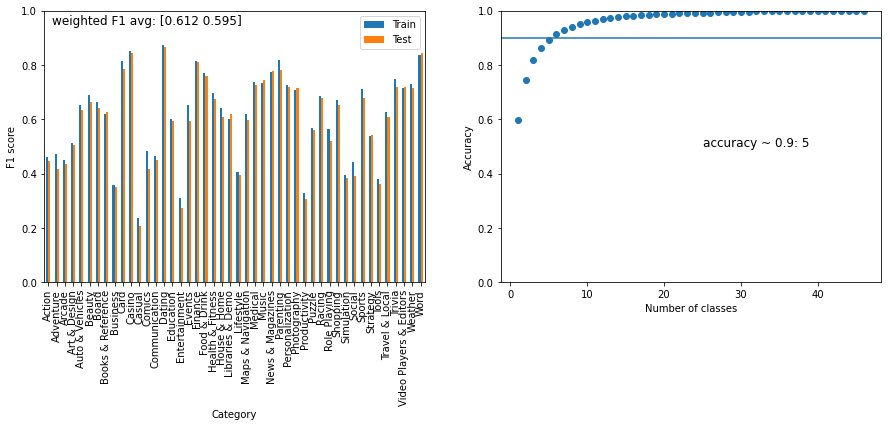

In [18]:
model = load_model("models/model_bayes.pkl")

y_test_prob = model.predict_proba(X_test)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

data_plot = {
    "y_train_pred": y_train_pred,
    "y_test_pred": y_test_pred,
    "y_test_prob": y_test_prob,
    "y_train": y_train,
    "y_test": y_test,
    "w_train": w_train
}

plot_summary(data_plot)

### Naive Bayes classifier with ngram(2,2)

In [ ]:
data_model = {
    "vector": CountVectorizer(min_df=5, max_df=0.7, ngram_range=(2,2)),
    "model": MultinomialNB(),
    "parameters": {"model__alpha": [0.0001, 1, 2, 3, 4, 5]},
    "X_train": X_train,
    "y_train": y_train
}

model = find_best_model(data_model, model__sample_weight=w_train)
save_model(model, "models/model_bayes_ngram.pkl")

# Fitting 3 folds for each of 6 candidates, totalling 18 fits
# [CV] END ................................model__alpha=0.0001; total time= 1.6min
# [CV] END ................................model__alpha=0.0001; total time= 1.6min
# [CV] END ................................model__alpha=0.0001; total time= 1.6min
# [CV] END .....................................model__alpha=1; total time= 1.6min
# [CV] END .....................................model__alpha=1; total time= 1.6min
# [CV] END .....................................model__alpha=1; total time= 1.6min
# [CV] END .....................................model__alpha=2; total time= 1.6min
# [CV] END .....................................model__alpha=2; total time= 1.6min
# [CV] END .....................................model__alpha=2; total time= 1.6min
# [CV] END .....................................model__alpha=3; total time= 1.6min
# [CV] END .....................................model__alpha=3; total time= 1.6min
# [CV] END .....................................model__alpha=3; total time= 1.6min
# [CV] END .....................................model__alpha=4; total time= 1.6min
# [CV] END .....................................model__alpha=4; total time= 1.6min
# [CV] END .....................................model__alpha=4; total time= 1.6min
# [CV] END .....................................model__alpha=5; total time= 1.6min
# [CV] END .....................................model__alpha=5; total time= 1.6min
# [CV] END .....................................model__alpha=5; total time= 1.6min
# Best parameters:
# {'model__alpha': 1}

/home/mmichalski/.anaconda3/envs/spacy/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1775: UndefinedMetricWarning: 'k' (46) greater than or equal to 'n_classes' (46) will result in a perfect score and is therefore meaningless.
  warnings.warn(


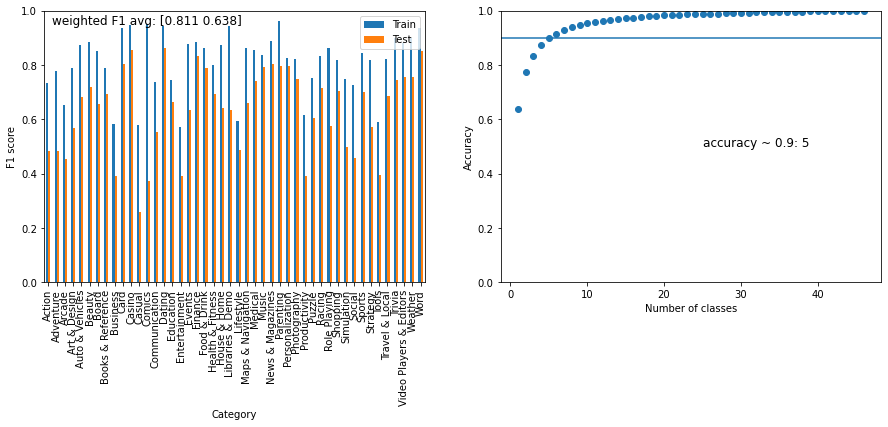

In [19]:
model = load_model("models/model_bayes_ngram.pkl")

y_test_prob = model.predict_proba(X_test)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

data_plot = {
    "y_train_pred": y_train_pred,
    "y_test_pred": y_test_pred,
    "y_test_prob": y_test_prob,
    "y_train": y_train,
    "y_test": y_test,
    "w_train": w_train
}

plot_summary(data_plot)

### Logistic Regression

In [ ]:
data_model = {
    "vector": CountVectorizer(min_df=5, max_df=0.7),
    "model": LogisticRegression(),
    "parameters": {"model__C": [0.001, 0.01, 0.1, 1]},
    "X_train": X_train,
    "y_train": y_train
}

model = find_best_model(data_model, model__sample_weight=w_train)
save_model(model, "models/model_lr.pkl")

# Fitting 3 folds for each of 4 candidates, totalling 12 fits
# [CV] END .....................................model__C=0.001; total time= 5.4min
# [CV] END .....................................model__C=0.001; total time= 5.5min
# [CV] END .....................................model__C=0.001; total time= 5.4min
# [CV] END ......................................model__C=0.01; total time= 5.3min
# [CV] END ......................................model__C=0.01; total time= 5.3min
# [CV] END ......................................model__C=0.01; total time= 5.3min
# [CV] END .......................................model__C=0.1; total time= 5.2min
# [CV] END .......................................model__C=0.1; total time= 5.3min
# [CV] END .......................................model__C=0.1; total time= 5.3min
# [CV] END .........................................model__C=1; total time= 5.3min
# [CV] END .........................................model__C=1; total time= 5.3min
# [CV] END .........................................model__C=1; total time= 5.2min
# Best parameters:
# {'model__C': 0.01}

/home/mmichalski/.anaconda3/envs/spacy/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1775: UndefinedMetricWarning: 'k' (46) greater than or equal to 'n_classes' (46) will result in a perfect score and is therefore meaningless.
  warnings.warn(


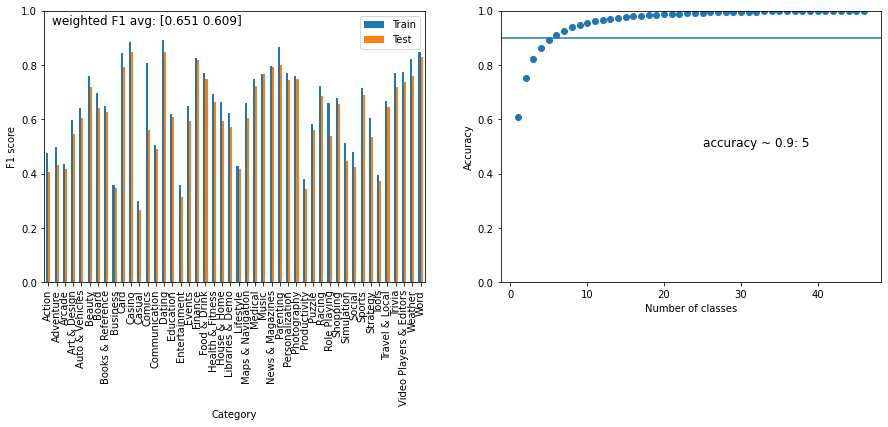

In [20]:
model = load_model("models/model_lr.pkl")

y_test_prob = model.predict_proba(X_test)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

data_plot = {
    "y_train_pred": y_train_pred,
    "y_test_pred": y_test_pred,
    "y_test_prob": y_test_prob,
    "y_train": y_train,
    "y_test": y_test,
    "w_train": w_train
}

plot_summary(data_plot)

### Boosted Random Forest (LightGBM)

In [ ]:
data_model = {
    "vector": CountVectorizer(min_df=5, max_df=0.7, dtype=np.float32),
    "model": lgbm.LGBMClassifier(device="gpu", objective="multiclass", 
                                 num_classes=48, verbose=-1),
    "parameters": {"model__n_estimators": [50, 100, 250]},
    "X_train": X_train,
    "y_train": y_train
}

model = find_best_model(data_model, model__sample_weight=w_train)
save_model(model, "models/model_lightgbm.pkl")

# Fitting 3 folds for each of 3 candidates, totalling 9 fits
# [CV] END .............................model__n_estimators=50; total time= 7.4min
# [CV] END .............................model__n_estimators=50; total time= 7.4min
# [CV] END .............................model__n_estimators=50; total time= 7.4min
# [CV] END ............................model__n_estimators=100; total time=12.1min
# [CV] END ............................model__n_estimators=100; total time=12.1min
# [CV] END ............................model__n_estimators=100; total time=12.1min
# [CV] END ............................model__n_estimators=250; total time=22.0min
# [CV] END ............................model__n_estimators=250; total time=22.0min
# [CV] END ............................model__n_estimators=250; total time=21.8min
# Best parameters:
# {'model__n_estimators': 100}

/home/mmichalski/.anaconda3/envs/spacy/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1775: UndefinedMetricWarning: 'k' (46) greater than or equal to 'n_classes' (46) will result in a perfect score and is therefore meaningless.
  warnings.warn(


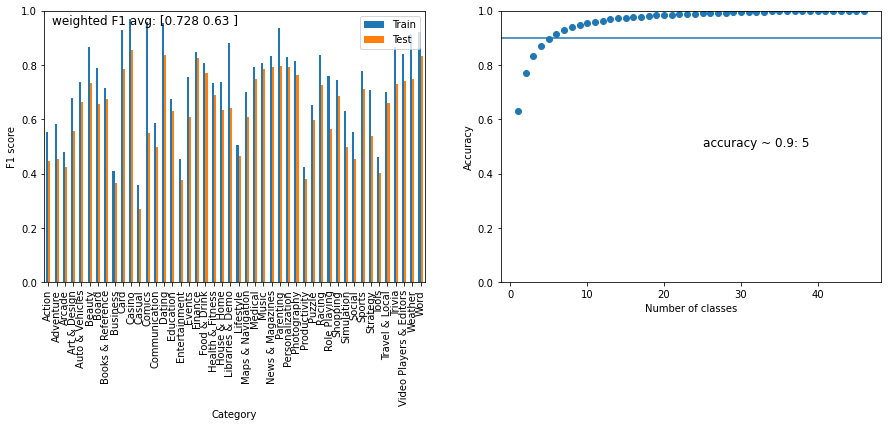

In [21]:
model = load_model("models/model_lightgbm.pkl")

y_test_prob = model.predict_proba(X_test)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

data_plot = {
    "y_train_pred": y_train_pred,
    "y_test_pred": y_test_pred,
    "y_test_prob": y_test_prob,
    "y_train": y_train,
    "y_test": y_test,
    "w_train": w_train
}

plot_summary(data_plot)

### Recurrent Neural Network (RNN)

In [ ]:
def perform_vectorization(X_train):
    encoder = tf.keras.layers.TextVectorization()
    encoder.adapt(X_train)
    
    return encoder

def create_rnn(X_train):
    encoder = perform_vectorization(X_train)
    
    rnn = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(46, activation="softmax")
    ])
    
    return rnn

def create_rnn_model(data_model):
    model = create_rnn(data_model["X_train"])
    
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=[tfa.metrics.F1Score(num_classes=46, 
                                               average="weighted")])
    
    model.fit(data_model["X_train"], data_model["y_train"], epochs=10, 
              validation_data=(data_model["X_test"], data_model["y_test"]),
              sample_weight=data_model["w_train"])
    
    return model

In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

data_model = {
    "X_train": X_train,
    "y_train": y_train_cat,
    "X_test": X_test,
    "y_test": y_test_cat,
    "w_train": w_train
}

model = create_rnn_model(data_model)
model.save("models/model_rnn")

# Epoch 1/10
# 34595/34595 [==============================] - 661s 19ms/step - loss: 2.4704 - f1_score: 0.2936 - val_loss: 1.9972 - val_f1_score: 0.4498
# Epoch 2/10
# 34595/34595 [==============================] - 655s 19ms/step - loss: 1.6330 - f1_score: 0.5055 - val_loss: 1.7133 - val_f1_score: 0.5273
# Epoch 3/10
# 34595/34595 [==============================] - 655s 19ms/step - loss: 1.4257 - f1_score: 0.5541 - val_loss: 1.5921 - val_f1_score: 0.5585
# Epoch 4/10
# 34595/34595 [==============================] - 654s 19ms/step - loss: 1.3214 - f1_score: 0.5775 - val_loss: 1.5506 - val_f1_score: 0.5690
# Epoch 5/10
# 34595/34595 [==============================] - 654s 19ms/step - loss: 1.2497 - f1_score: 0.5924 - val_loss: 1.5106 - val_f1_score: 0.5738
# Epoch 6/10
# 34595/34595 [==============================] - 654s 19ms/step - loss: 1.1961 - f1_score: 0.6031 - val_loss: 1.4904 - val_f1_score: 0.5780
# Epoch 7/10
# 34595/34595 [==============================] - 654s 19ms/step - loss: 1.1512 - f1_score: 0.6119 - val_loss: 1.4805 - val_f1_score: 0.5820
# Epoch 8/10
# 34595/34595 [==============================] - 654s 19ms/step - loss: 1.1118 - f1_score: 0.6197 - val_loss: 1.4454 - val_f1_score: 0.5860
# Epoch 9/10
# 34595/34595 [==============================] - 654s 19ms/step - loss: 1.0772 - f1_score: 0.6268 - val_loss: 1.4372 - val_f1_score: 0.5909
# Epoch 10/10
# 34595/34595 [==============================] - 654s 19ms/step - loss: 1.0460 - f1_score: 0.6336 - val_loss: 1.4943 - val_f1_score: 0.5785
# INFO:tensorflow:Assets written to: models/model_rnn/assets

34595/34595 [==============================] - 209s 6ms/step


/home/mmichalski/.anaconda3/envs/spacy/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1775: UndefinedMetricWarning: 'k' (46) greater than or equal to 'n_classes' (46) will result in a perfect score and is therefore meaningless.
  warnings.warn(


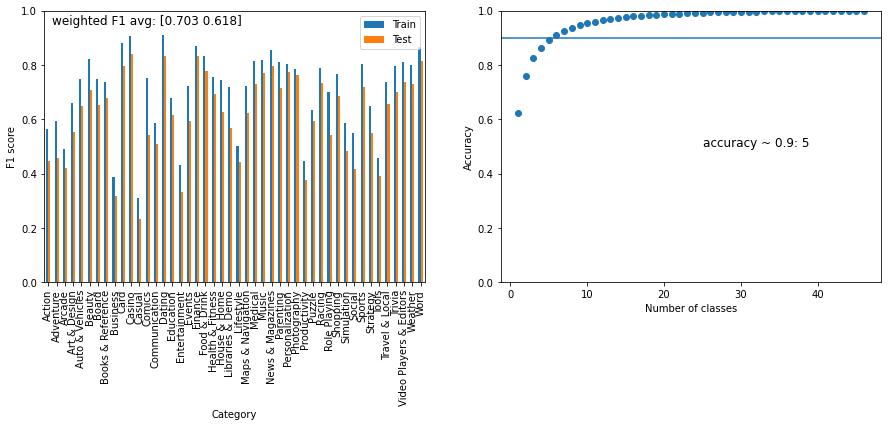

In [22]:
model = tf.keras.models.load_model("models/model_rnn")

y_test_prob = model.predict(X_test, verbose=1)
y_test_pred = np.argmax(y_test_prob, axis=-1)
y_train_pred = np.argmax(model.predict(X_train, verbose=1), axis=-1)

data_plot = {
    "y_train_pred": y_train_pred,
    "y_test_pred": y_test_pred,
    "y_test_prob": y_test_prob,
    "y_train": y_train,
    "y_test": y_test,
    "w_train": w_train
}

plot_summary(data_plot)

## Selecting the best model

Analyzing the results of the averaged and weighted F1 score, we can concluded that the above models behave very similarly. This is due to the fact that created categories do not quite describe the applications in the store. For example, an application that was placed in the "Medical" category may just as well be in the "Tools" or "Business". Therefore, in addition to analyzing the F1 score, we should also verify how many classes the correctly classified applications fall into. As one may see, we can classify 90% of applications with just top 5 probable classes.

Based on the above analysis, we can conclude that the naive Bayes classifier with ngram correction turned out to be the best classifier. It is also worth noting that it was the fastest learning ML model. Therefore, it is the one chosen for further validation.

### Cross validation

In [ ]:
folds = KFold(n_splits=10, random_state=42, shuffle=True)

for train_idx, test_idx in folds.split(df):
    f_X_train, f_y_train = df["Words"].iloc[train_idx], labels[train_idx]
    f_X_test, f_y_test = df["Words"].iloc[test_idx], labels[test_idx]
    f_w_train = compute_sample_weight("balanced", f_y_train)
    
    pipeline = Pipeline([("vector", CountVectorizer(min_df=5, max_df=0.7, 
                                                    ngram_range=(2,2))), 
                         ("model", MultinomialNB(alpha=1))])
    
    pipeline.fit(f_X_train, f_y_train, 
                 model__sample_weight=f_w_train)

    f1 = weighted_f1(f_y_test, pipeline.predict(f_X_test))
    top = top_k_accuracy(f_y_test, pipeline.predict_proba(f_X_test), k=5)
    
    print(f"F1: {f1}, top accuracy: {top}")
    
# F1: 0.6340517254436809, top accuracy: 0.895724666512896
# F1: 0.6367626099390978, top accuracy: 0.8975535191253643
# F1: 0.6327031649424115, top accuracy: 0.8935586679848747
# F1: 0.6312160736395034, top accuracy: 0.890518629899828
# F1: 0.6341063911489085, top accuracy: 0.8925497216574599
# F1: 0.6342843637127572, top accuracy: 0.8939554177719379
# F1: 0.6325766274413099, top accuracy: 0.8929817082242341
# F1: 0.6312130904438951, top accuracy: 0.8959166095169658
# F1: 0.6312051360612346, top accuracy: 0.891309929705863
# F1: 0.636656076795608, top accuracy: 0.8950469759167503

Performed cross validation reveals that model does not have overfitting problem. It achieves stable F1 score values at 0.633 ± 0.002 and accuracy of top 5 classes at 0.894 ± 0.002.

Now we can also verify model on new data. Let's create our own descriptions and check class prediction.

In [23]:
def if_english(doc):
    if "en" in doc._.language["language"]:
        return True

    return False

def check_tokens(token):
    conditions = [not token.like_num, not token.like_url,
                  not token.like_email, not token.is_oov,
                  not token.is_stop, token.is_ascii,
                  token.is_alpha, len(token.lemma_) > 2]

    return all(conditions)

def split_words(X):
    soup = BeautifulSoup(X)
    doc = nlp(soup.get_text().lower())
    words = []
        
    if if_english(doc):
        words += [token.lemma_ for token in doc 
                  if check_tokens(token)]

    return [" ".join(words)]

def get_pred_category(model, labels, k, words):
    if len(words) == 0:
        return []
    
    pred_prob = model.predict_proba(words)
    top_idx = np.argsort(pred_prob, axis=1)[:,-k:]

    top_prob = pred_prob[0][top_idx]
    top_labels = labels[top_idx[0]]

    stacked = np.dstack((top_labels, top_prob))
    stacked = np.hstack(stacked)

    return stacked[stacked[:,1].argsort(axis=0)][::-1]

class Text2CategoryTransformer(BaseEstimator, ClusterMixin):
    def __init__(self, model, labels, k):
        self.model = model
        self.labels_ = labels
        self.k = k
    
    def fit(self, X, y = None):
        return self
    
    def predict(self, X, y = None):
        words = split_words(X)
        category = get_pred_category(self.model, self.labels_, 
                                     self.k, words)
        return category
        
    def fit_predict(self, X, y = None):
        self.fit(X, y)
        return self.predict(X, y)

In [24]:
example_input = {
    "app1": "This app will help you study quantum chemistry and pass all exams.",
    "app2": "Do you need help? This app will help you with medical problems.",
    "app3": "Make purchases from stores around the world!"
}

model = load_model("models/model_bayes_ngram.pkl")

pipeline = Pipeline([
    ("Text2Category", Text2CategoryTransformer(model=model, labels=le.classes_, k=5))
])

for app_name, description in example_input.items():
    result = pipeline.fit_predict(description)
    print(app_name, result)

app1 [['Education' 0.9481529678624089]
 ['Medical' 0.020376483529759244]
 ['Trivia' 0.012249699879920969]
 ['Books & Reference' 0.010495648003804155]
 ['Entertainment' 0.0018190794226125757]]
app2 [['Medical' 0.8431832219637667]
 ['Parenting' 0.09422911726952812]
 ['Health & Fitness' 0.05791756172371074]
 ['Education' 0.0011337683839506946]
 ['Lifestyle' 0.000824600355528625]]
app3 [['Shopping' 0.8397344727500052]
 ['Comics' 0.04528788598580879]
 ['Action' 0.015298520362785964]
 ['Food & Drink' 0.013157047446371582]
 ['Casino' 0.009388835356719041]]


All classes are correctly fitted. However, we need to take into account that if we use more sophisticated description, this model may suggest few classes with similar probability.

## Conclusions

As a part of the course, I conducted a classification of more than 1 million mobile apps. The data was downloaded directly from the Google Play store. After that, I performed statistical analysis and prepared ML models to assign apps to one of 46 classes.

The naive Bayes classifier turned out to be the best classifier. It shows both the highest F1 score and top 5 class prediction at ~90%. Unfortunately, I was not able to get a high F1 score when classifying directly into one class. Mobile apps do not always allow easy assignment. In the Google Play store we can find 46 unique classes, some of them are very similar to each other. It means that mobile apps might be (and should be) classified into more than one class.

## Acknowledgments

The author is grateful to the Wroclaw Centre for Networking and Supercomputing for generous allocation of computer time.